### Import Library

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

from scipy.optimize import OptimizeResult

### Define Noise Model

In [29]:
p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])

### Molecular Parameter

In [30]:
# paramters for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226
nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

### Define Utility

In [31]:
class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []

def get_probability_distribution(counts, shots):
    # Probability Distribution
    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0 # if k isn't already a key in 'counts', add k to counts with a value of 0
    sorted_counts = sorted(counts.items()) # sort the items (key-value pairs) by key
    # print("Sorted Counts:", counts)

    output_distr = [ v[1] / shots for v in sorted_counts ] # normalize
    if (len(output_distr) == 1):
        output_distr.append(1-output_distr[0]) # handle single outcome case
    # print("Output Distribution", output_distr)
    
    return output_distr

### Define Optimizer

In [32]:
# Adam Optimizer

def compute_value_and_grad(x_opt, function, eps):
    f = function(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = function(x_plus_h)
        grad[i] = (f_plus_h - f) / eps
    # print("eps: ", eps)
    return f, grad


def adam_optimizer(function, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    
    # learning rate
    base_learning_rate = 0.1

    # Adam Variables
    t = 0
    m_t = 0
    v_t = 0

    # Optimization Results
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # compute the function value and gradient
        val, grad = compute_value_and_grad(x_opt, function, eps)
        nfev += 2
        njev += 1

        function_val = val

        # Adam Update
        t += 1
        m_t = beta1*m_t + (1-beta1)*grad
        v_t = beta2*v_t + (1-beta2)*grad**2
        m_t_hat = m_t / (1-beta1**t)
        v_t_hat = v_t / (1-beta2**t)

        current_learning_rate = 0.5 * base_learning_rate * ( math.cos(math.pi*nit/maxiter) + 1 )
        learning_rate = current_learning_rate / ( np.sqrt(v_t_hat)+epsilon )

        # Update Parameters
        x_opt = x_opt - learning_rate*m_t_hat
        
        nit += 1
    
    result = OptimizeResult(fun=function_val, x=x_opt, nit=nit, njev=njev, success=success, message=message)
    return result

### Define Backend Simulator

In [36]:

backend = QasmSimulator(method='statevector', noise_model=noise_model)

def simulator(theta, shots, history):
    print('Iter: ', len(history.energies))
    E = g0 + nuclear_repulsion
    
    # Expectation value of <Z0>, <Z1>, <Z2>
    circuit_1 = QuantumCircuit(2,2)
    circuit_1.name = 'H2 STO-3G g1-g3'
    circuit_1.x(0)
    circuit_1.ry(np.pi/2,1)
    circuit_1.rx(3*np.pi/2,0)
    circuit_1.cx(1,0)
    circuit_1.rz(theta[0],0)
    circuit_1.cx(1,0)
    circuit_1.ry(3*np.pi/2,1)
    circuit_1.rx(np.pi/2,0)
    circuit_1.measure(range(2), range(2))

    # Get the expectation value of <Y0Y1>
    circuit_2 = QuantumCircuit(2,2)
    circuit_2.name = "H2 STO-3G g4"
    circuit_2.x(0)
    circuit_2.ry(np.pi/2,1)
    circuit_2.rx(3*np.pi/2,0)
    circuit_2.cx(1,0)
    circuit_2.rz(theta[0],0)
    circuit_2.cx(1,0)
    circuit_2.ry(3*np.pi/2,1)
    circuit_2.rx(np.pi/2,0)
    circuit_2.sdg(1)
    circuit_2.h(1)
    circuit_2.sdg(0)
    circuit_2.h(0)
    circuit_2.measure(range(2), range(2))

    # Get the expectation value of <X0X1>
    circuit_3 = QuantumCircuit(2,2)
    circuit_3.name = "H2 STO-3G g5"
    circuit_3.x(0)
    circuit_3.ry(np.pi/2,1)
    circuit_3.rx(3*np.pi/2,0)
    circuit_3.cx(1,0)
    circuit_3.rz(theta[0],0)
    circuit_3.cx(1,0)
    circuit_3.ry(3*np.pi/2,1)
    circuit_3.rx(np.pi/2,0)
    circuit_3.h(1)
    circuit_3.h(0)
    circuit_3.measure(range(2), range(2))


    shots1, shots2, shots3 = shots

    # print(shots1)
    # Run Circuit 1
    transpiled_circuit_1 = transpile(circuit_1, backend)
    job = backend.run(transpiled_circuit_1, shots=shots1)
    result = job.result()
    # print("Result", result)
    counts = result.get_counts(circuit_1)
    # print(" == = counts 1: ", counts)
    output_distr = get_probability_distribution(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # Run Circuit 2    
    transpiled_circuit_2 = transpile(circuit_2, backend)
    job = backend.run(transpiled_circuit_2, shots=shots2)
    result = job.result()
    counts = result.get_counts(circuit_2)
    # print("counts 2: ", counts)
    output_distr = get_probability_distribution(counts, shots2)
    history.P2.append(output_distr)

    E +=  g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])

    # Run Circuit 3
    transpiled_circuit = transpile(circuit_3, backend)
    job = backend.run(transpiled_circuit, shots=shots3)
    result = job.result()
    counts = result.get_counts(circuit_3)
    output_distr = get_probability_distribution(counts, shots3)
    history.P3.append(output_distr)

    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    


    # print("E: ", E)
    history.thetas.append(theta)
    history.energies.append(E)
    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1], "\n")

    return E
    # return circuit.draw('mpl', reverse_bits=True)

### Run Simulator

In [37]:
theta_test = [0]
record_history = history()
shots=600
per_shots = shots // 3

result = adam_optimizer (lambda x: simulator(x, shots=(per_shots, per_shots, per_shots), history=record_history), theta_test, iters=500, eps=0.02)

Iter:  0
theta track:  [0]
energy track:  -0.5834390057999999 

Iter:  1
theta track:  [0]
energy track:  -0.5570830058 

Iter:  2
theta track:  [-0.1]
energy track:  -0.3074530058 

Iter:  3
theta track:  [-0.08]
energy track:  -0.2959910058 

Iter:  4
theta track:  [-0.19514209]
energy track:  -0.3451990058 

Iter:  5
theta track:  [-0.17514209]
energy track:  -0.41838500579999993 

Iter:  6
theta track:  [-0.15628565]
energy track:  -0.3699480058 

Iter:  7
theta track:  [-0.13628565]
energy track:  -0.33305300579999997 

Iter:  8
theta track:  [-0.15279769]
energy track:  -0.2878030058 

Iter:  9
theta track:  [-0.13279769]
energy track:  -0.31681100580000005 

Iter:  10
theta track:  [-0.13240276]
energy track:  -0.3707290058 

Iter:  11
theta track:  [-0.11240276]
energy track:  -0.3652450058 

Iter:  12
theta track:  [-0.1180402]
energy track:  -0.3067240058 

Iter:  13
theta track:  [-0.0980402]
energy track:  -0.3567610058 

Iter:  14
theta track:  [-0.08247194]
energy track: 

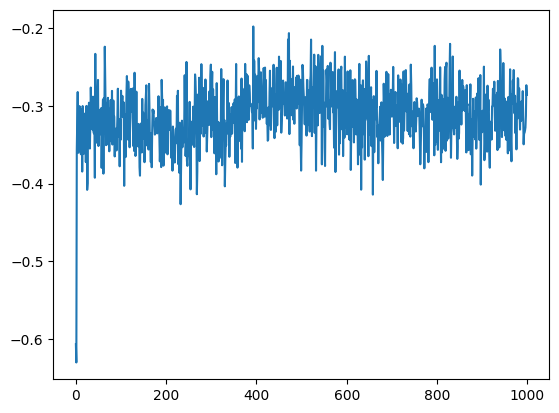

In [26]:
plt.plot(record_history.energies)

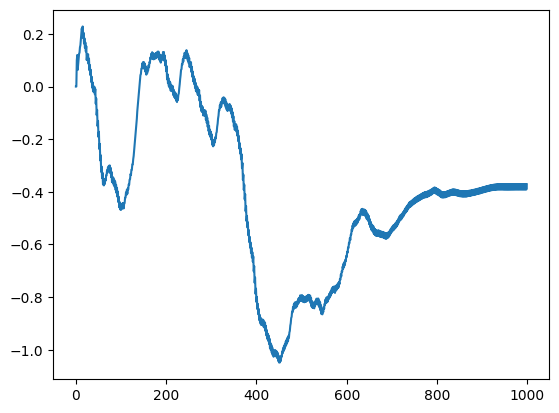

In [27]:
plt.plot(record_history.thetas)